# Understanding the Impact of Learning Rate in a Deep Neural Network

## Preliminaries

In [1]:
# Necessities
import os
import numpy as np

# Deep Learning
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.optim import Adam

# Data Visualization
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt 
%matplotlib inline

# wandb
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\hp/.netrc


True

## Global Configuration

In [15]:
class config:
    DATA_DIRECTORY = 'D:/Blog Code/impact-of-learning-rate-in-nn/input/'
    MODEL_DIRECTORY = 'D:/Blog Code/impact-of-learning-rate-in-nn/models'
    MODEL_HIGH_LR_PATH = os.path.join(MODEL_DIRECTORY, 'model_high_lr.pth')
    MODEL_MID_LR_PATH = os.path.join(MODEL_DIRECTORY, 'model_mid_lr.pth')
    MODEL_LOW_LR_PATH = os.path.join(MODEL_DIRECTORY, 'model_low_lr.pth')

    DATA_DOWNLOAD = False

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    NUM_EPOCHS = 5
    HIGH_LEARNING_RATE = 1e-1
    MEDIUM_LEARNING_RATE = 1e-3
    LOW_LEARNING_RATE = 1e-5
    BATCH_SIZE = 32

# Load Datasets

In [16]:
# Download Data

data = datasets.FashionMNIST(
    config.DATA_DIRECTORY,
    download=config.DATA_DOWNLOAD,
    train=True
    )

In [17]:
# Train Dataset

fmnist = datasets.FashionMNIST(
    root=config.DATA_DIRECTORY,
    download=config.DATA_DOWNLOAD,
    train=True
    )

tr_images = fmnist.data
tr_targets = fmnist.targets 

# Validation Dataset

val_fmnist = datasets.FashionMNIST(
    config.DATA_DIRECTORY,
    download=config.DATA_DOWNLOAD,
    train=False
    )

val_images = val_fmnist.data 
val_targets = val_fmnist.targets 

# Dataset Class

In [18]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255       # Scaling the Data
        x = x.view(-1,28*28)
        self.x = x
        self.y = y 

    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix] 

        return x.to(config.DEVICE), y.to(config.DEVICE)
        
    def __len__(self): 
        return len(self.x)

# Model

In [19]:
def get_model(lr):
    """
    Function to obtain the model, loss function and optimizer

    Args:
        lr (float): Learning Rate for Optimizer

    Returns:
        model: A Deel Learning Model
        loss_fn: Loss Function
        optimizer: Optimizer to update parameters
    """
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(config.DEVICE)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = Adam(model.parameters(), lr=lr)
    
    return model, loss_fn, optimizer

# Training and Validation Functions

In [20]:
def train_batch(x, y, model, optimizer, loss_fn):
    """
    Function to train one batch of Training Data

    Args:
        x (numpy array): Input Features
        y (numpy array): Labels
        model: Deep Learning Model
        optimizer: Optimizer
        loss_fn: Loss Function

    Returns:
        batch_loss.item(): Loss value for the batch
    """
    model.train()                       # Set model to training mode
    prediction = model(x)               # Obtain Predictions
    batch_loss = loss_fn(prediction, y) # Calculate Loss for the batch
    batch_loss.backward()               # Backward Propagation of Loss
    optimizer.step()                    # Update Parameters
    optimizer.zero_grad()               # Zero the gradients
    return batch_loss.item()

def accuracy(x, y, model):
    """
    Function to calculate the accuracy of the model

    Args:
        x (numpy array): Input Features
        y (numpy array): Labels
        model: Deep Learning Model

    Returns:
        is_correct.cpu().numpy().tolist() (list): List of correct predictions
    """
    model.eval()                                # Set model to evaluation mode
    with torch.no_grad():                       # Initialize torch.no_grad()
        prediction = model(x)                   # Obtain predictions on evaluation set
    max_values, argmaxes = prediction.max(-1)   # Obtain class prediction with maximum value
    is_correct = argmaxes == y                  # Number of correct predictions
    return is_correct.cpu().numpy().tolist()

# Utilities

In [21]:
def get_data(): 
    """
    Function to obtain the Training and Validation DataLoaders

    Returns:
        train_dl: Training DataLoader
        val_dl: Validation DataLoader
    """
    train = FMNISTDataset(tr_images, tr_targets) 
    train_dl = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return train_dl, val_dl

In [27]:
@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    """
    Function to calculate Validation Loss

    Args:
        x (numpy array): Input Features
        y (numpy array): Labels
        model: Deep Learning Model
        loss_fn: Loss Function

    Returns:
        val_loss.item(): Validation Loss Value
    """
    prediction = model(x)               # Obtain Model Predictions
    val_loss = loss_fn(prediction, y)   # Calculate Validation Loss
    return val_loss.item()

In [23]:
def get_loss_plot(lr, train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Function to plot the training and validation losses

    Args:
        lr (float): Learning Rate on which the model was trained
        train_losses (list): List of training losses
        val_losses (list): List of validation losses
        train_accuracies (list): List of training accuracies
        val_accuracies (list): List of validation accuracies
    """
    epochs = np.arange(config.NUM_EPOCHS)+1

    plt.subplot(211)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title(f'Training and validation loss with {lr} learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()

    plt.subplot(212)
    plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title(f'Training and validation accuracy with {lr} learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

In [33]:
def get_hist_plot(lr, path):
    """
    Function to plot the histogram of the model parameters

    Args:
        lr (float): Learning Rate
        path (str): Path of the model
    """

    # Load Model
    model, _, _ = get_model(lr)
    model.load_state_dict(torch.load(path))

    # Plot Histogram
    for ix, par in enumerate(model.parameters()):

        if(ix==0):
            plt.hist(par.cpu().detach().numpy().flatten())
            plt.title('Distribution of weights conencting input to hidden layer')
            plt.show()

        elif(ix ==1):
            plt.hist(par.cpu().detach().numpy().flatten())
            plt.title('Distribution of biases of hidden layer')
            plt.show()

        elif(ix==2):
            plt.hist(par.cpu().detach().numpy().flatten())
            plt.title('Distribution of weights conencting hidden to output layer')
            plt.show()
            
        elif(ix ==3):
            plt.hist(par.cpu().detach().numpy().flatten())
            plt.title('Distribution of biases of output layer')
            plt.show() 

# Engine

In [28]:
def run(lr, path):
    """
    Function to run the model training

    Args:
        lr (float) : Learning Rate for the optimizer
        path (str): Path of the model

    Returns:
        train_losses (list): List of training losses
        val_losses (list): List of validation losses
        train_accuracies (list): List of training accuracies
        val_accuracies (list): List of validation accuracies
    """

    # Load Dataloaders
    train_dl, val_dl = get_data()
    
    model, loss_fn, optimizer = get_model(lr)
    
    # Define lists to store losses and accuracies
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Initialize wandb
    run = wandb.init(project='impact-of-learning-rate-in-nn')

    for epoch in range(config.NUM_EPOCHS):

        print(f"########## Epoch: {epoch} ##########")

        train_epoch_losses, train_epoch_accuracies = [], []

        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            batch_loss = train_batch(
                x, 
                y, 
                model, 
                optimizer, 
                loss_fn
                )
            train_epoch_losses.append(batch_loss) 
            
        train_epoch_loss = np.array(train_epoch_losses).mean()
        print(f"Epoch Train Loss: {train_epoch_loss}")
        print()

        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)

        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        for ix, batch in enumerate(iter(val_dl)):
            x, y = batch
            val_is_correct = accuracy(x, y, model)
            validation_loss = val_loss(x, y, model, loss_fn)
            
        val_epoch_accuracy = np.mean(val_is_correct)
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(validation_loss)
        val_accuracies.append(val_epoch_accuracy)

        wandb.log(
            {   'epoch': epoch,
                'train_loss': train_epoch_loss,
                'train_accuracy': train_epoch_accuracy,
                'val_loss': validation_loss,
                'val_accuracy': val_epoch_accuracy
            }
        )

    torch.save(model.state_dict(), path)

    wandb.finish()

    return train_losses, val_losses, train_accuracies, val_accuracies

---

### 1. High Learning Rate (1e-1)

In [29]:
train_losses, val_losses, train_accuracies, val_accuracies = run(
                                                               config.HIGH_LEARNING_RATE, 
                                                               config.MODEL_HIGH_LR_PATH
                                                            )

########## Epoch: 0 ##########
Epoch Train Loss: 3.2213793676376343

########## Epoch: 1 ##########
Epoch Train Loss: 1.547328098710378

########## Epoch: 2 ##########
Epoch Train Loss: 1.4944892586390177

########## Epoch: 3 ##########
Epoch Train Loss: 1.552152773284912

########## Epoch: 4 ##########
Epoch Train Loss: 1.5256847016334534



epoch,▁▃▅▆█
train_accuracy,▃█▁▅▅
train_loss,█▁▁▁▁
val_accuracy,▄█▁▅▆
val_loss,▁▁▆▂█
epoch,4
train_accuracy,0.40315
train_loss,1.52568
val_accuracy,0.4044
val_loss,1.67748


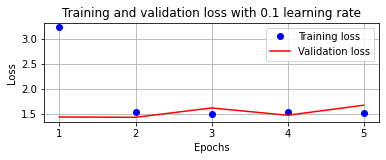

C:\Users\hp\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


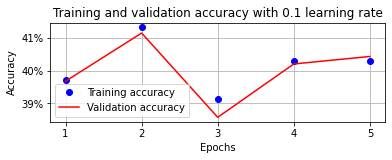

In [30]:
get_loss_plot(
    config.HIGH_LEARNING_RATE, 
    train_losses, 
    val_losses, 
    train_accuracies, 
    val_accuracies
    )

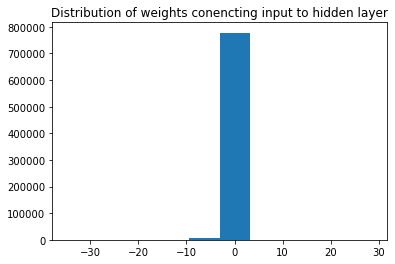

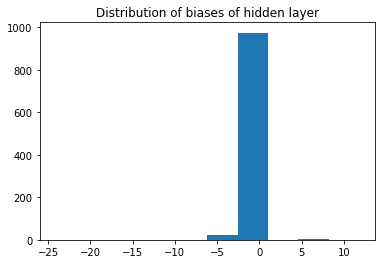

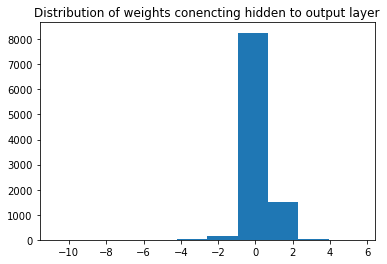

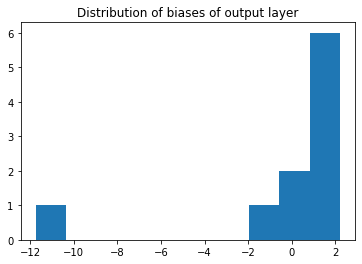

In [34]:
get_hist_plot(
    config.HIGH_LEARNING_RATE, 
    config.MODEL_HIGH_LR_PATH
    )

---

### 2. Medium Learning Rate (1e-3)

In [35]:
train_losses, val_losses, train_accuracies, val_accuracies = run(
                                                                config.MEDIUM_LEARNING_RATE, 
                                                                config.MODEL_MID_LR_PATH
                                                            )

########## Epoch: 0 ##########
Epoch Train Loss: 0.4755789047837257

########## Epoch: 1 ##########
Epoch Train Loss: 0.35740708833932877

########## Epoch: 2 ##########
Epoch Train Loss: 0.32273957402507464

########## Epoch: 3 ##########
Epoch Train Loss: 0.29861713925798733

########## Epoch: 4 ##########
Epoch Train Loss: 0.27857878862023355



epoch,▁▃▅▆█
train_accuracy,▁▄▆██
train_loss,█▄▃▂▁
val_accuracy,▁▃▇██
val_loss,█▆▂▂▁
epoch,4
train_accuracy,0.90235
train_loss,0.27858
val_accuracy,0.8767
val_loss,0.34298


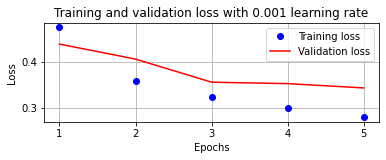

C:\Users\hp\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


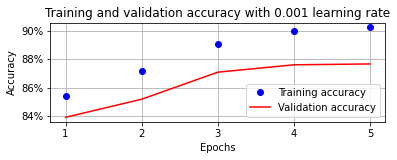

In [37]:
get_loss_plot(
    config.MEDIUM_LEARNING_RATE, 
    train_losses, 
    val_losses, 
    train_accuracies, 
    val_accuracies
    )

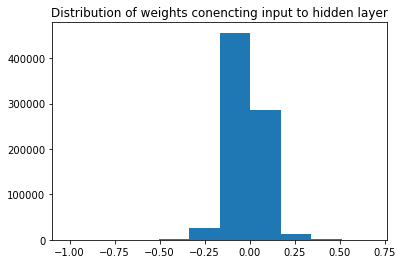

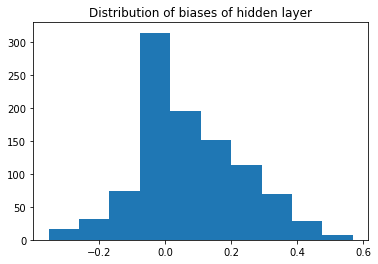

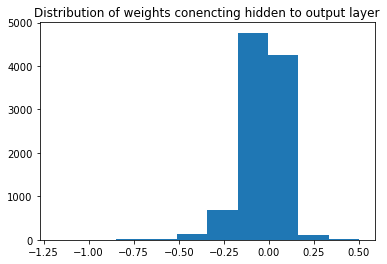

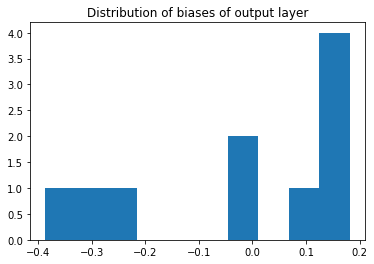

In [38]:
get_hist_plot(
    config.MEDIUM_LEARNING_RATE, 
    config.MODEL_MID_LR_PATH
    )

---

### 3. Low Learning Rate (1e-5)

In [39]:
train_losses, val_losses, train_accuracies, val_accuracies = run(
                                                                config.LOW_LEARNING_RATE, 
                                                                config.MODEL_LOW_LR_PATH
                                                            )

########## Epoch: 0 ##########
Epoch Train Loss: 1.1911172279675801

########## Epoch: 1 ##########
Epoch Train Loss: 0.6918770170847575

########## Epoch: 2 ##########
Epoch Train Loss: 0.5941883036454518

########## Epoch: 3 ##########
Epoch Train Loss: 0.5444398608207702

########## Epoch: 4 ##########
Epoch Train Loss: 0.5132244038661321



epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,4
train_accuracy,0.83288
train_loss,0.51322
val_accuracy,0.8222
val_loss,0.52531


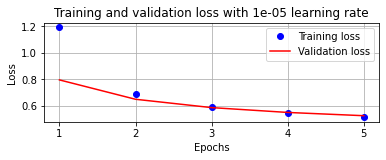

C:\Users\hp\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


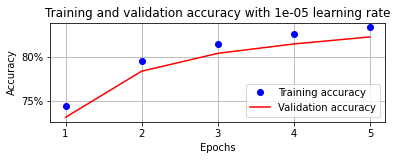

In [40]:
get_loss_plot(
    config.LOW_LEARNING_RATE, 
    train_losses, 
    val_losses, 
    train_accuracies, 
    val_accuracies
    )

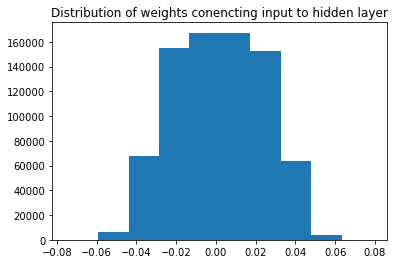

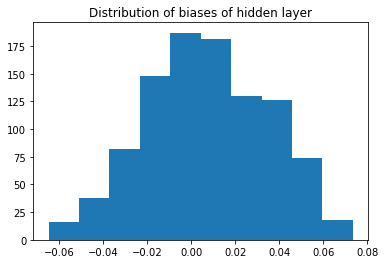

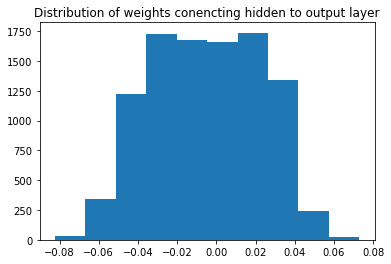

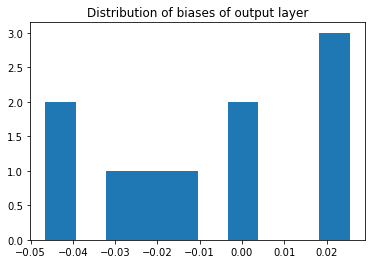

In [41]:
get_hist_plot(
    config.LOW_LEARNING_RATE,
    config.MODEL_LOW_LR_PATH
    )

---